In [1]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [28]:
dataset_filename = os.listdir("D:")[0]
dataset_path = os.path.join("D:","Tweets.csv")
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: D:Tweets.csv


In [29]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [30]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [31]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [32]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 446 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

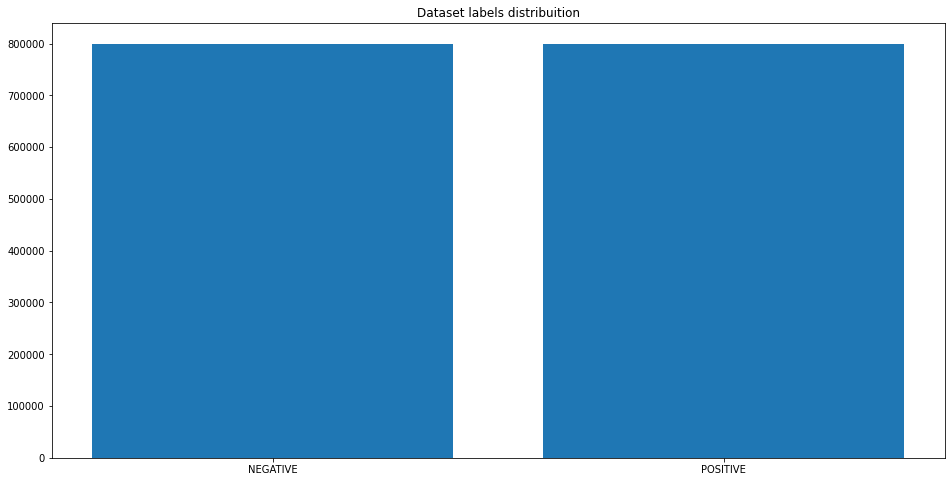

In [33]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [34]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")


In [35]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [36]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 42.7 s


In [37]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [39]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 2.58 s


In [40]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [41]:
w2v_model.build_vocab(documents)

2020-12-01 22:15:54,810 : INFO : collecting all words and their counts
2020-12-01 22:15:54,811 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-01 22:15:54,827 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-12-01 22:15:54,846 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-12-01 22:15:54,866 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-12-01 22:15:54,884 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-12-01 22:15:54,902 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-12-01 22:15:54,921 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-12-01 22:15:54,942 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-12-01 22:15:54,962 : INFO : PROGRESS: at s

2020-12-01 22:15:56,178 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-12-01 22:15:56,196 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-12-01 22:15:56,211 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-12-01 22:15:56,231 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-12-01 22:15:56,253 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-12-01 22:15:56,269 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-12-01 22:15:56,285 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-12-01 22:15:56,307 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-12-01 22:15:56,325 : INFO : PROGRESS: at sentence #800000, processed 577088

In [42]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [43]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-12-01 22:16:24,089 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-12-01 22:16:25,109 : INFO : EPOCH 1 - PROGRESS: at 17.24% examples, 1410636 words/s, in_qsize 16, out_qsize 1
2020-12-01 22:16:26,109 : INFO : EPOCH 1 - PROGRESS: at 33.06% examples, 1355455 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:16:27,116 : INFO : EPOCH 1 - PROGRESS: at 46.46% examples, 1268622 words/s, in_qsize 16, out_qsize 1
2020-12-01 22:16:28,128 : INFO : EPOCH 1 - PROGRESS: at 58.26% examples, 1191475 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:16:29,130 : INFO : EPOCH 1 - PROGRESS: at 67.66% examples, 1107983 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:16:30,139 : INFO : EPOCH 1 - PROGRESS: at 76.55% examples, 1043671 words/s, in_qsize 13, out_qsize 2
2020-12-01 22:16:31,148 : INFO : EPOCH 1 - PROGRESS: at 86.21% examples, 1006737 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:16:31,989 : INFO : worker threa

2020-12-01 22:17:01,845 : INFO : EPOCH - 5 : training on 9227204 raw words (8223031 effective words) took 7.5s, 1102876 effective words/s
2020-12-01 22:17:02,869 : INFO : EPOCH 6 - PROGRESS: at 16.27% examples, 1324778 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:17:03,875 : INFO : EPOCH 6 - PROGRESS: at 33.48% examples, 1365515 words/s, in_qsize 13, out_qsize 2
2020-12-01 22:17:04,880 : INFO : EPOCH 6 - PROGRESS: at 50.67% examples, 1380275 words/s, in_qsize 14, out_qsize 1
2020-12-01 22:17:05,888 : INFO : EPOCH 6 - PROGRESS: at 67.99% examples, 1389083 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:17:06,889 : INFO : EPOCH 6 - PROGRESS: at 85.13% examples, 1392212 words/s, in_qsize 16, out_qsize 0
2020-12-01 22:17:07,711 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 22:17:07,713 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 22:17:07,715 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 22:

2020-12-01 22:17:38,941 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 22:17:38,942 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 22:17:38,943 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 22:17:38,944 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 22:17:38,949 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 22:17:38,951 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-01 22:17:38,959 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-01 22:17:38,963 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-01 22:17:38,965 : INFO : EPOCH - 11 : training on 9227204 raw words (8222712 effective words) took 7.2s, 1147830 effective words/s
2020-12-01 22:17:39,990 : INFO : EPOCH 12 - PROGRESS: at 16.59% examples, 1348638 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:17:

2020-12-01 22:18:10,350 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-01 22:18:10,351 : INFO : EPOCH - 16 : training on 9227204 raw words (8223999 effective words) took 6.0s, 1371098 effective words/s
2020-12-01 22:18:11,367 : INFO : EPOCH 17 - PROGRESS: at 16.27% examples, 1333345 words/s, in_qsize 12, out_qsize 3
2020-12-01 22:18:12,368 : INFO : EPOCH 17 - PROGRESS: at 32.94% examples, 1351750 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:18:13,370 : INFO : EPOCH 17 - PROGRESS: at 49.59% examples, 1357483 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:18:14,372 : INFO : EPOCH 17 - PROGRESS: at 65.17% examples, 1338725 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:18:15,378 : INFO : EPOCH 17 - PROGRESS: at 81.23% examples, 1332670 words/s, in_qsize 14, out_qsize 1
2020-12-01 22:18:16,378 : INFO : EPOCH 17 - PROGRESS: at 98.04% examples, 1340503 words/s, in_qsize 16, out_qsize 1
2020-12-01 22:18:16,446 : INFO : worker thread finished; awaiting finish o

2020-12-01 22:18:46,957 : INFO : EPOCH 22 - PROGRESS: at 82.10% examples, 1345315 words/s, in_qsize 14, out_qsize 1
2020-12-01 22:18:47,969 : INFO : EPOCH 22 - PROGRESS: at 94.79% examples, 1292188 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:18:48,286 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-12-01 22:18:48,288 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-12-01 22:18:48,291 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 22:18:48,293 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 22:18:48,301 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 22:18:48,303 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-01 22:18:48,312 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-01 22:18:48,318 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-01 22:18:48,318 : INFO : EPOCH -

2020-12-01 22:19:19,704 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-12-01 22:19:19,705 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 22:19:19,713 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 22:19:19,717 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-01 22:19:19,721 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-01 22:19:19,725 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-01 22:19:19,726 : INFO : EPOCH - 27 : training on 9227204 raw words (8222038 effective words) took 6.3s, 1314885 effective words/s
2020-12-01 22:19:20,749 : INFO : EPOCH 28 - PROGRESS: at 15.73% examples, 1279090 words/s, in_qsize 12, out_qsize 3
2020-12-01 22:19:21,752 : INFO : EPOCH 28 - PROGRESS: at 31.97% examples, 1306577 words/s, in_qsize 15, out_qsize 0
2020-12-01 22:19:22,761 : INFO : EPOCH 28 - PROGRESS: at 48.30% examples, 1315176 w

2020-12-01 22:19:54,989 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-12-01 22:19:54,991 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-12-01 22:19:54,995 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-12-01 22:19:55,005 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-12-01 22:19:55,006 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-12-01 22:19:55,007 : INFO : EPOCH - 32 : training on 9227204 raw words (8221792 effective words) took 9.6s, 852186 effective words/s
2020-12-01 22:19:55,009 : INFO : training on a 295270528 raw words (263128026 effective words) took 210.9s, 1247533 effective words/s


Wall time: 3min 30s


(263128026, 295270528)

In [44]:
w2v_model.most_similar("love")

C:\Users\adity\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-12-01 22:20:39,481 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5773587226867676),
 ('loves', 0.5746666193008423),
 ('loved', 0.5297864675521851),
 ('amazing', 0.5061787366867065),
 ('adore', 0.5031328797340393),
 ('looove', 0.4756856858730316),
 ('awesome', 0.4613794684410095),
 ('loveee', 0.4592064321041107),
 ('lovee', 0.4511285424232483),
 ('loooove', 0.44009190797805786)]

In [46]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 12.7 s


In [47]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 20.4 s


In [48]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [49]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [50]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [51]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [52]:
# Embedding layer

In [53]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [54]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [55]:
# Bulding model

In [56]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________
